# Analysis of comment moderation results (A/B/C policies)

This notebook:

- Loads:
  - `../data/comments.csv`
  - `../results/comments_with_policy_results.csv`
- Computes:
  - Overall distribution of decisions (BLOCK / WARN_AND_ALLOW / ALLOW) per policy
  - Average tone and debate-value scores per policy
  - Decision maps in tone–debate space (scatter + BLOCK probability heatmap)
  - Cases where policies disagree (e.g., A=BLOCK, C=ALLOW)
- Produces:
  - Summary tables (for slides / report)
  - Optional simple visualizations (bar charts, scatter plots, heatmaps) using matplotlib

Assumptions:

- This notebook is located in `notebooks/` directory of the project.
- Folder structure:

    project_root 
             
      ├─ data/ 
      │   └─ comments.csv 
      ├─ results/ 
      │   └─ comments_with_policy_results.csv 
      └─ notebooks/ 
          └─ analysis_comments_results.ipynb (this file)


In [1]:
# Standard imports
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set up paths assuming this notebook is in `notebooks/`
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"

COMMENTS_CSV = DATA_DIR / "comments.csv"
RESULTS_CSV = RESULTS_DIR / "comments_with_policy_results.csv"

print("Project root :", PROJECT_ROOT)
print("Comments CSV :", COMMENTS_CSV)
print("Results CSV  :", RESULTS_CSV)


Project root : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_자유게시판_iter2
Comments CSV : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_자유게시판_iter2\data\comments.csv
Results CSV  : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_자유게시판_iter2\results\comments_with_policy_results.csv


In [2]:
# Load original comments (one row per sample_id)
comments_df = pd.read_csv(COMMENTS_CSV)
print(f"Loaded {len(comments_df)} rows from comments.csv")
display(comments_df.head())

# Load policy results (one row per sample_id x policy)
results_df = pd.read_csv(RESULTS_CSV)
print(f"Loaded {len(results_df)} rows from comments_with_policy_results.csv")
display(results_df.head())

# Merge results with original text so that every row has the comment text
merged_df = results_df.merge(
    comments_df[["sample_id", "thread_id", "role", "order_in_thread", "text"]],
    on=["sample_id", "thread_id", "role", "order_in_thread"],
    how="left",
    suffixes=("", "_orig"),
)

print(f"Merged rows: {len(merged_df)}")
display(merged_df.head())


Loaded 182 rows from comments.csv


,sample_id,thread_id,role,order_in_thread,text
0,1,1,post,0,얼마나 인기없으면 글이 안올라오냐
1,2,1,comment,1,뭐?
2,3,1,comment,2,?
3,4,2,post,0,그냥 궁금해서 하는 투표 AI 쓰면 안되는 시험/과제에서 솔직히 쓴 적 있다/없다 ...
4,5,2,comment,1,과제는 많이들 ai 조금이라도 써봤을듯


Loaded 546 rows from comments_with_policy_results.csv


,sample_id,thread_id,role,order_in_thread,policy,decision,short_reason,tone_score,debate_value_score
0,1,1,post,0,A,ALLOW,욕설이나 인신공격이 없고 단순한 비판·불만 표현으로 판단됨.,2,2
1,1,1,post,0,B,ALLOW,욕설·인신공격 없고 토론 가치가 낮지만 허용 기준에 부합함.,2,2
2,1,1,post,0,C,ALLOW,위협·신상털이·혐오가 없고 단순한 불만 표현으로 자유롭게 허용함.,2,2
3,2,1,comment,1,A,ALLOW,욕설·비속어가 없고 인신공격도 없는 단순한 의문 표현으로 비판·불만이 아님.,1,1
4,2,1,comment,1,B,ALLOW,욕설·인신공격이 없고 토론 가치가 낮은 단순 의문 표현이지만 허용됨.,1,1


Merged rows: 546


,sample_id,thread_id,role,order_in_thread,policy,decision,short_reason,tone_score,debate_value_score,text
0,1,1,post,0,A,ALLOW,욕설이나 인신공격이 없고 단순한 비판·불만 표현으로 판단됨.,2,2,얼마나 인기없으면 글이 안올라오냐
1,1,1,post,0,B,ALLOW,욕설·인신공격 없고 토론 가치가 낮지만 허용 기준에 부합함.,2,2,얼마나 인기없으면 글이 안올라오냐
2,1,1,post,0,C,ALLOW,위협·신상털이·혐오가 없고 단순한 불만 표현으로 자유롭게 허용함.,2,2,얼마나 인기없으면 글이 안올라오냐
3,2,1,comment,1,A,ALLOW,욕설·비속어가 없고 인신공격도 없는 단순한 의문 표현으로 비판·불만이 아님.,1,1,뭐?
4,2,1,comment,1,B,ALLOW,욕설·인신공격이 없고 토론 가치가 낮은 단순 의문 표현이지만 허용됨.,1,1,뭐?


## 1. Decision distribution per policy

Decision counts per policy:


decision,ALLOW,BLOCK,WARN_AND_ALLOW
policy,,,
A,160,19,3
B,160,19,3
C,165,2,15


Decision percentages per policy (%):


decision,ALLOW,BLOCK,WARN_AND_ALLOW
policy,,,
A,87.9,10.4,1.6
B,87.9,10.4,1.6
C,90.7,1.1,8.2


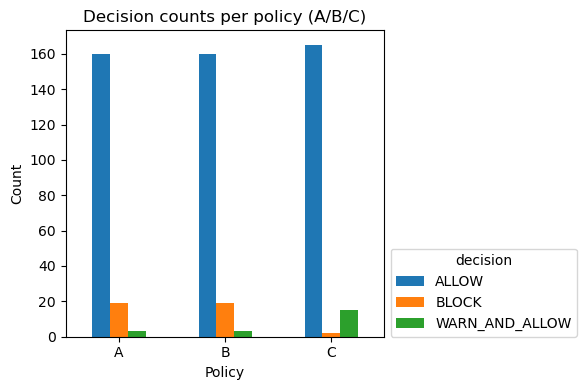

In [3]:
# Decision counts per policy
decision_summary = (
    merged_df
    .groupby(["policy", "decision"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

print("Decision counts per policy:")
display(decision_summary)

# Also compute row-wise percentages
decision_pct = decision_summary.div(decision_summary.sum(axis=1), axis=0) * 100
print("Decision percentages per policy (%):")
display(decision_pct.round(1))

# Simple bar chart for decision distribution per policy
# (Uses matplotlib only, no custom colors)
ax = decision_summary.plot(
    kind="bar",
    rot=0,
    figsize=(6, 4),
)
ax.set_xlabel("Policy")
ax.set_ylabel("Count")
ax.set_title("Decision counts per policy (A/B/C)")
ax.legend(
    title="decision",
    loc="lower left",
    bbox_to_anchor=(1.02, 0),
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


## 2. Average tone_score and debate_value_score per policy

Average tone_score and debate_value_score per policy:


,tone_score,debate_value_score
policy,,
A,1.56,1.77
B,1.55,1.80
C,1.57,1.77


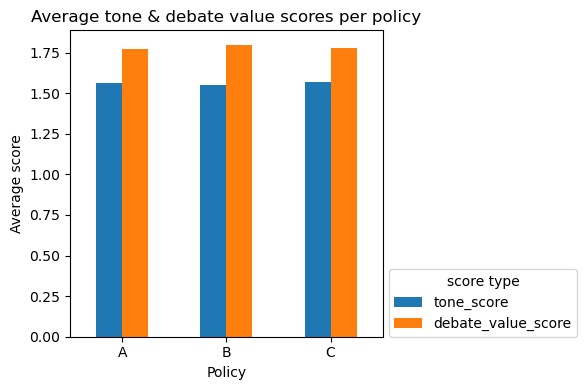

In [4]:
# Average scores per policy
score_summary = (
    merged_df
    .groupby("policy")[["tone_score", "debate_value_score"]]
    .mean()
    .sort_index()
)

print("Average tone_score and debate_value_score per policy:")
display(score_summary.round(2))

# Bar plots for scores (optional)
ax = score_summary.plot(
    kind="bar",
    rot=0,
    figsize=(6, 4),
)
ax.set_xlabel("Policy")
ax.set_ylabel("Average score")
ax.set_title("Average tone & debate value scores per policy")
ax.legend(
    title="score type",
    loc="lower left",
    bbox_to_anchor=(1.02, 0),
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


## 3. Decision maps in tone–debate space

In this section, we visualize how each policy (A/B/C) makes moderation decisions
across the 2D space of **tone_score** (1 = polite, 5 = aggressive) and
**debate_value_score** (1 = low, 5 = high).

We first draw scatter plots (one panel per policy), and then heatmaps showing
the probability of **BLOCK** in each (tone, debate) cell. This reveals which
regions of the space each policy tends to treat more harshly (high BLOCK rate)
or more leniently.


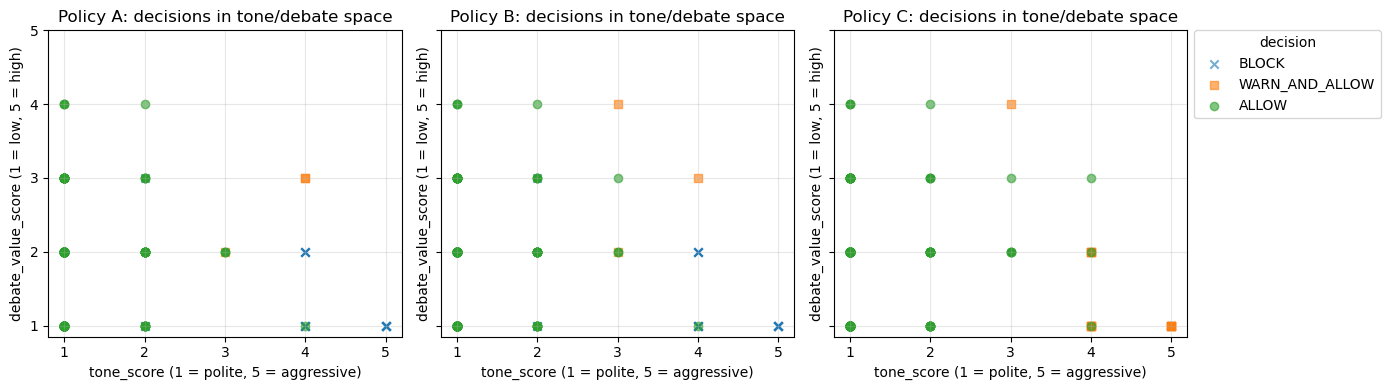

In [5]:
# 3.1 Scatter: decision by tone_score & debate_value_score for each policy

policies = ["A", "B", "C"]
decisions = ["BLOCK", "WARN_AND_ALLOW", "ALLOW"]
markers = {
    "BLOCK": "x",
    "WARN_AND_ALLOW": "s",
    "ALLOW": "o",
}

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

for ax, pol in zip(axes, policies):
    sub = merged_df[merged_df["policy"] == pol].copy()
    # Drop rows with missing scores
    sub = sub.dropna(subset=["tone_score", "debate_value_score"])

    for dec in decisions:
        sub_dec = sub[sub["decision"] == dec]
        if sub_dec.empty:
            continue
        ax.scatter(
            sub_dec["tone_score"],
            sub_dec["debate_value_score"],
            alpha=0.6,
            marker=markers[dec],
            label=dec,
        )

    ax.set_title(f"Policy {pol}: decisions in tone/debate space")
    ax.set_xlabel("tone_score (1 = polite, 5 = aggressive)")
    ax.set_ylabel("debate_value_score (1 = low, 5 = high)")
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.grid(True, alpha=0.3)

# Legend shown once, on the right of the last panel
axes[-1].legend(
    title="decision",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_23468\1645278950.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


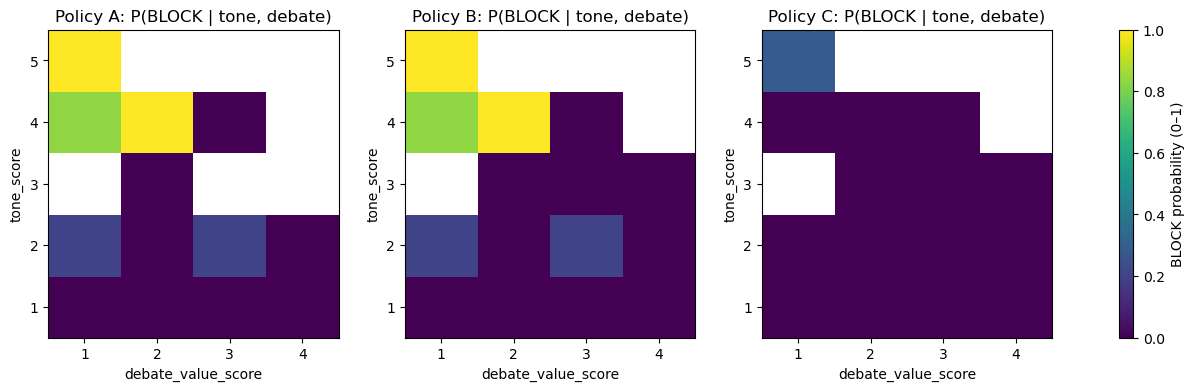

In [6]:
# 3.2 Heatmaps: P(BLOCK | tone_score, debate_value_score) per policy

def make_block_rate_heatmap(df, policy_id):
    """
    Compute P(BLOCK | tone_score, debate_value_score) for a given policy.

    Returns:
        tones: sorted list of tone_score values
        debates: sorted list of debate_value_score values
        block_rate: 2D numpy array with shape (len(tones), len(debates))
    """
    sub = df[df["policy"] == policy_id].copy()
    sub = sub.dropna(subset=["tone_score", "debate_value_score"])

    tones = sorted(sub["tone_score"].unique())
    debates = sorted(sub["debate_value_score"].unique())

    block_rate = np.full((len(tones), len(debates)), np.nan)

    for i, t in enumerate(tones):
        for j, d in enumerate(debates):
            cell = sub[(sub["tone_score"] == t) & (sub["debate_value_score"] == d)]
            if len(cell) == 0:
                continue
            rate = (cell["decision"] == "BLOCK").mean()
            block_rate[i, j] = rate

    return tones, debates, block_rate


import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(
    1, 4,
    width_ratios=[1, 1, 1, 0.05],  
    wspace=0.3,
)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])  

last_im = None

for ax, pol in zip(axes, ["A", "B", "C"]):
    tones, debates, block_rate = make_block_rate_heatmap(merged_df, pol)

    im = ax.imshow(
        block_rate,
        origin="lower",
        vmin=0,
        vmax=1,
        aspect="auto",
    )
    last_im = im

    ax.set_title(f"Policy {pol}: P(BLOCK | tone, debate)")
    ax.set_xticks(range(len(debates)))
    ax.set_yticks(range(len(tones)))
    ax.set_xticklabels(debates)
    ax.set_yticklabels(tones)
    ax.set_xlabel("debate_value_score")
    ax.set_ylabel("tone_score")

cbar = fig.colorbar(last_im, cax=cax)
cbar.set_label("BLOCK probability (0–1)")

fig.tight_layout()
plt.show()


## 4. Cases where policies disagree on decision

In [7]:
# Pivot decisions to one row per sample_id
pivot_decisions = (
    merged_df
    .pivot_table(
        index="sample_id",
        columns="policy",
        values="decision",
        aggfunc="first",
    )
    .sort_index()
)

# Filter rows where not all three policies agree
disagree_mask = pivot_decisions.nunique(axis=1) > 1
disagree_samples = pivot_decisions[disagree_mask].copy()

print(f"Number of samples where policies disagree: {len(disagree_samples)}")
display(disagree_samples.head())

# Attach original text for context
disagree_with_text = (
    disagree_samples
    .reset_index()
    .merge(
        comments_df[["sample_id", "thread_id", "role", "order_in_thread", "text"]],
        on="sample_id",
        how="left",
    )
    .sort_values("sample_id")
)

print("Disagreement cases with comment text:")
display(disagree_with_text.head(20))

# Save disagreement cases to CSV for convenient use in slides / report
disagree_path = RESULTS_DIR / "disagreement_cases_with_text.csv"
disagree_with_text.to_csv(disagree_path, index=False, encoding="utf-8-sig")

print("Saved disagreement cases to:", disagree_path)


Number of samples where policies disagree: 20


policy,A,B,C
sample_id,,,
26,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW
30,BLOCK,BLOCK,WARN_AND_ALLOW
31,BLOCK,BLOCK,WARN_AND_ALLOW
53,BLOCK,BLOCK,WARN_AND_ALLOW
80,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW


Disagreement cases with comment text:


,sample_id,A,B,C,thread_id,role,order_in_thread,text
0,26,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,5,post,0,전전 3.6졸이면 ㅁㅌㅊ임? 전공 성적은 3.9 넘고 기초랑 교양에서 많이 까먹긴함
1,30,BLOCK,BLOCK,WARN_AND_ALLOW,5,comment,4,4.1졸이면 ㅁㅌㅊ임?
2,31,BLOCK,BLOCK,WARN_AND_ALLOW,5,comment,5,이건 걍 ㅅㅌㅊ아님?ㄷㄷ
3,53,BLOCK,BLOCK,WARN_AND_ALLOW,7,comment,1,빌넣 받아주셔요
4,80,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,10,comment,8,헌급방은 빡셈
5,83,BLOCK,BLOCK,ALLOW,10,comment,11,남자답게 해병대에 입대하자
6,85,BLOCK,BLOCK,WARN_AND_ALLOW,10,comment,13,공군은 사회적으로 나는 폐급이란걸 인정하는거임
7,86,BLOCK,BLOCK,WARN_AND_ALLOW,10,comment,14,라고 사회생활 안해본애가 얘기하는중 ㅋ
8,87,BLOCK,BLOCK,WARN_AND_ALLOW,10,comment,15,"친한 애들은 편하다고 존나 부러워하고, 육군 해병대 애들은 3개월 도르 물고 늘어지..."
9,88,BLOCK,BLOCK,WARN_AND_ALLOW,11,post,0,올해 수능친사람 ㅈㄱㄴ


Saved disagreement cases to: C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_자유게시판_iter2\results\disagreement_cases_with_text.csv


## 5. Thread-level decision overview

In [8]:
# For each thread, show how many comments are blocked vs allowed under each policy.

thread_policy_summary = (
    merged_df
    .groupby(["thread_id", "policy", "decision"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .sort_values(["thread_id", "policy"])
)

print("Thread-level decision distribution:")
display(thread_policy_summary.head(20))

# Export to CSV if needed
thread_summary_path = RESULTS_DIR / "thread_policy_summary.csv"
thread_policy_summary.to_csv(thread_summary_path, index=False, encoding="utf-8-sig")
print("Saved thread-level summary to:", thread_summary_path)


Thread-level decision distribution:


decision,thread_id,policy,ALLOW,BLOCK,WARN_AND_ALLOW
0,1,A,3,0,0
1,1,B,3,0,0
2,1,C,3,0,0
3,2,A,7,0,0
4,2,B,7,0,0
5,2,C,7,0,0
6,3,A,8,0,0
7,3,B,8,0,0
8,3,C,8,0,0
9,4,A,7,0,0


Saved thread-level summary to: C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_자유게시판_iter2\results\thread_policy_summary.csv
